In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import os
import time
import numba
import subprocess
#
#import pyspark
import h5py
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
#
def date_to_string(dt):
    return "{}-{}-{}T{}:{}:{}".format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#

In [3]:
format_list = ['User', 'Group', 'GID', 'Jobname', 'JobID', 'JobIDRaw', 'partition', 'state', 'time', 'ncpus',
               'nnodes', 'Submit', 'Eligible', 'start', 'end', 'elapsed', 'SystemCPU', 'UserCPU',
               'TotalCPU', 'NTasks', 'CPUTimeRaw', 'Suspended', 'ReqTRES', 'AllocTRES']
#
end_time = dtm.datetime.now().date()
start_time = end_time - dtm.timedelta(days=180)
#
print('** start: {}'.format(start_time))
print(f'** end: {end_time}')
#
#
#data_file_name = 'data/mazama_usage_20200506_tool8.out'
#data_file_name = 'data/sacct_sherlock_out_serc2020_05_08.out'
data_file_name = 'data/serc_usage_{}.out'.format(end_time)
#
pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
h5_name = "{}.h5".format(os.path.splitext(data_file_name)[0])
#
#sacct_FORMAT = 'User,Group,GID,Jobname,JobID,JobIDRaw,partition,state,time,ncpus,nnodes,Submit,Eligible,start,end,elapsed,SystemCPU,UserCPU,TotalCPU,NTasks,CPUTimeRaw,Suspended,ReqGRES,AllocGRES,ReqTRES,AllocTRES'
#format_list = [str(s) for s in sacct_FORMAT.split(',')]
#print('** ', format_list)
#
#
# construct start,end times array:
start_end_times = [(start_time, min(start_time + dtm.timedelta(days=30), end_time))]
options  = [('group', 'oneillm'), ('delimiter', '"|"'), ('allusers',None)]
#
while start_end_times[-1][1] < end_time:
    start_end_times += [[start_end_times[-1][1], min(start_end_times[-1][1] + dtm.timedelta(days=30), end_time) ]]
#
# NOTE: Sherlock will only allow one month of sacct query, so we break this up. I usually just do 15th - 15th,
#. but maybe we can be a bit more sophisticated here.
#  TODO: include time, but I'm not sure of the correct format right now (ie, yyyy-mm-ddThh:mm:ss, yyyy-mm-dd hh:mm:ss,
#. and then )
print('** Start_end_times: ', start_end_times)
#

# TODO: these are cut-pasted from .sh; reformat.
sacct_format = ','.join(format_list)
#

#
options_str = ''

for (op,vl) in options:
    if vl is None:
        options_str += '--{}'.format(op)
    else:
        options_str += ' --{}={} '.format(op,vl)
#
print('** options: ', options_str)

** start: 2021-07-23
** end: 2022-01-19
** Start_end_times:  [(datetime.date(2021, 7, 23), datetime.date(2021, 8, 22)), [datetime.date(2021, 8, 22), datetime.date(2021, 9, 21)], [datetime.date(2021, 9, 21), datetime.date(2021, 10, 21)], [datetime.date(2021, 10, 21), datetime.date(2021, 11, 20)], [datetime.date(2021, 11, 20), datetime.date(2021, 12, 20)], [datetime.date(2021, 12, 20), datetime.date(2022, 1, 19)]]
** options:   --group=oneillm  --delimiter="|" --allusers


In [4]:
#
sacct_out = ''
Ss = []
for k, (start, stop) in enumerate(start_end_times):
    sacct_str = 'sacct {} {} -p --starttime={} --endtime={} --format={} '.format( ('--noheader' if k>0 else ''), 
                                    options_str, start, stop, sacct_format )
    #
    #sacct_str_list = sacct_str.split()
    #break
    print('** [{}]: {}\n'.format(k, sacct_str))
    #
    S = subprocess.run(sacct_str.split(), stdout=subprocess.PIPE)
    # TODO: parallelize...
    Ss += S.stdout.decode()
    sacct_out += S.stdout.decode()



** [0]: sacct   --group=oneillm  --delimiter="|" --allusers -p --starttime=2021-07-23 --endtime=2021-08-22 --format=User,Group,GID,Jobname,JobID,JobIDRaw,partition,state,time,ncpus,nnodes,Submit,Eligible,start,end,elapsed,SystemCPU,UserCPU,TotalCPU,NTasks,CPUTimeRaw,Suspended,ReqTRES,AllocTRES 

** [1]: sacct --noheader  --group=oneillm  --delimiter="|" --allusers -p --starttime=2021-08-22 --endtime=2021-09-21 --format=User,Group,GID,Jobname,JobID,JobIDRaw,partition,state,time,ncpus,nnodes,Submit,Eligible,start,end,elapsed,SystemCPU,UserCPU,TotalCPU,NTasks,CPUTimeRaw,Suspended,ReqTRES,AllocTRES 

** [2]: sacct --noheader  --group=oneillm  --delimiter="|" --allusers -p --starttime=2021-09-21 --endtime=2021-10-21 --format=User,Group,GID,Jobname,JobID,JobIDRaw,partition,state,time,ncpus,nnodes,Submit,Eligible,start,end,elapsed,SystemCPU,UserCPU,TotalCPU,NTasks,CPUTimeRaw,Suspended,ReqTRES,AllocTRES 

** [3]: sacct --noheader  --group=oneillm  --delimiter="|" --allusers -p --starttime=2021

In [7]:
print('** ', len(sacct_out.split('\n')))

**  17152


In [6]:
for rw in sacct_out.split('\n')[0:10]:
    print('** ', rw)

**  User"|"Group"|"GID"|"JobName"|"JobID"|"JobIDRaw"|"Partition"|"State"|"Timelimit"|"NCPUS"|"NNodes"|"Submit"|"Eligible"|"Start"|"End"|"Elapsed"|"SystemCPU"|"UserCPU"|"TotalCPU"|"NTasks"|"CPUTimeRAW"|"Suspended"|"ReqTRES"|"AllocTRES"|"
**  regirock"|"oneillm"|"328022"|"SST_300"|"28964547"|"28964547"|"serc"|"TIMEOUT"|"7-00:00:00"|"240"|"10"|"2021-07-17T10:06:52"|"2021-07-17T10:06:52"|"2021-07-17T10:06:57"|"2021-07-24T10:07:31"|"7-00:00:34"|"519-15:06:06"|"1158-20:38:25"|"1678-11:44:32"|""|"145160160"|"00:00:00"|"billing=840,cpu=240,mem=2400G,node=10"|"billing=840,cpu=240,mem=2400G,node=10"|"
**  "|""|""|"batch"|"28964547.batch"|"28964547.batch"|""|"CANCELLED"|""|"24"|"1"|"2021-07-17T10:06:57"|"2021-07-17T10:06:57"|"2021-07-17T10:06:57"|"2021-07-24T10:07:35"|"7-00:00:38"|"00:00.147"|"00:00.576"|"00:00.723"|"1"|"14516112"|"00:00:00"|""|"cpu=24,mem=240G,node=1"|"
**  "|""|""|"extern"|"28964547.extern"|"28964547.extern"|""|"COMPLETED"|""|"240"|"10"|"2021-07-17T10:06:57"|"2021-07-17T10:06:5

In [7]:
print('** ', sacct_str_list)

NameError: name 'sacct_str_list' is not defined

In [ ]:
XX = subprocess.run(sacct_str_list, stdout=subprocess.PIPE)

In [ ]:
XX.stdout.decode()[0:10]

In [ ]:
xx = hpc_lib.SACCT_data_direct(group='oneillm', start_date=dtm.datetime(2020,8,1), end_date=dtm.datetime(2020,10,31))

In [ ]:
fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')

#
zz = xx.compute_vol_distributions_report(ax1=ax1, ax2=ax2)
ax1.grid()
ax2.grid()

In [11]:
S=hpc_lib.SACCT_data_direct(group='oneillm', start_date='2021-10-19', end_date='2022-01-19', n_cpu=4, verbose=1)


*** DEBUG: Now execute load_sacct_data()


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:496: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "process_row" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/users/myoder96/Codes/HPC_analytics/hpc_lib.py (502)

File "hpc_lib.py", line 502:
    def process_row(self, rw, headers=None, RH=None):
        <source elided>
        #
        headers = (headers or self.headers)
        ^

  @numba.jit
/home/groups/s-ees/share/cees/software/x86_64_arch/anaconda/3.8.8/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "process_row" was compiled in object mode without forceobj=True.

File "hpc_lib.py", line 497:
    @numba.jit
    def process_row(self, rw, headers=None, RH=None):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/groups/s-ees/share/cees/software/x86_64_arch/anaconda/3.8.8/lib/python3.8/site-packages/numba/core/object_mode_passes.py:

*** DEBUG: load_sacct_data() executed. Compute calc_jobs_summary()
*** calc_jobs_summary: with prams: len(data)=12849, verbose=1, n_cpu=4, step_size=100000
*** computing jobs_summary func on 4 cpu
** calc_summary:: ks: [    0 12850]
*** computing jobs_summary func on 1 cpu
Starting jobs_summary...


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:2541: RuntimeWarning: All-NaN slice encountered
  numpy.nanmax(sub_data['NTasks']).astype(int)


** DEBUG: jobs_summary.shape = (4264,)
*** calc_jobs_summary: results [r.get() ] list set.
** DEBUG: shapes:: (4264,), (4264,)


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1216: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


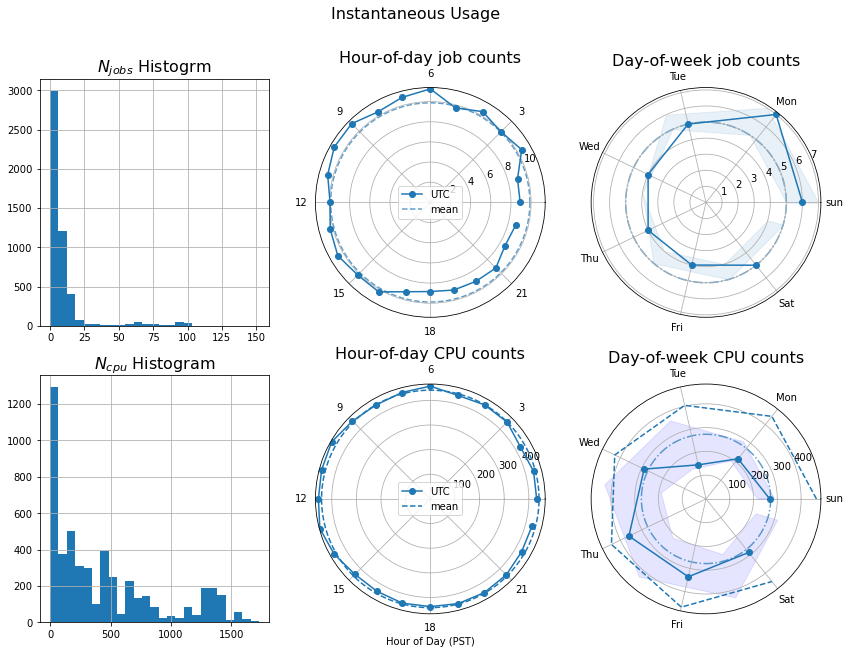

In [13]:
zz=S.active_cpu_jobs_per_day_hour_report(periodic_projection='polar')


In [21]:
S_normal = hpc_lib.SACCT_data_direct(group=None, partition='normal', 
                                     start_date='2022-01-01', end_date='2022-01-19', n_cpu=4, verbose=0,
                                    keep_raw_data=True)

*** DEBUG: Now execute load_sacct_data()


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:496: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "process_row" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/users/myoder96/Codes/HPC_analytics/hpc_lib.py (502)

File "hpc_lib.py", line 502:
    def process_row(self, rw, headers=None, RH=None):
        <source elided>
        #
        headers = (headers or self.headers)
        ^

  @numba.jit
/home/groups/s-ees/share/cees/software/x86_64_arch/anaconda/3.8.8/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "process_row" was compiled in object mode without forceobj=True.

File "hpc_lib.py", line 497:
    @numba.jit
    def process_row(self, rw, headers=None, RH=None):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/groups/s-ees/share/cees/software/x86_64_arch/anaconda/3.8.8/lib/python3.8/site-packages/numba/core/object_mode_passes.py:

*** DEBUG: load_sacct_data() executed. Compute calc_jobs_summary()


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:2537: RuntimeWarning: All-NaN slice encountered
  jobs_summary[['End', 'Start', 'NCPUS', 'NNodes', 'NTasks']][k] = numpy.nanmax(sub_data['End']),\
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:2538: RuntimeWarning: All-NaN slice encountered
  numpy.nanmin(sub_data['Start']),\
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:2541: RuntimeWarning: All-NaN slice encountered
  numpy.nanmax(sub_data['NTasks']).astype(int)
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:2541: RuntimeWarning: All-NaN slice encountered
  numpy.nanmax(sub_data['NTasks']).astype(int)
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:2541: RuntimeWarning: All-NaN slice encountered
  numpy.nanmax(sub_data['NTasks']).astype(int)
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:2541: RuntimeWarning: All-NaN slice encountered
  numpy.nanmax(sub_data['NTasks']).astype(int)
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:2537: RuntimeWarning: All

In [20]:
len(S_normal. data)



AttributeError: 'SACCT_data_direct' object has no attribute 'data'

In [ ]:
report_normal = hpc_lib.SACCT_groups_analyzer_report_handler(Short_title='normal partition', 
                                        Full_title='Sherlock "normal" partition HPC analytics', SACCT_obj=S_normal)

In [15]:
len(S_Normal.data)


NameError: name 'S_Normal' is not defined